### This session is made to train the lenet using lasagne and then perform FPGA speed up on PYNQ

In [1]:
#import caffe 
import sys
caffe_root = '/home/xilinx/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe

### Load the pretrained Caffe network

In [2]:
net_caffe = caffe.Net('lenet.prototxt', 'lenet_iter_10000.caffemodel', caffe.TEST)

### Import Lasagne

In [3]:
import os
import lasagne
import numpy as np
import theano
import theano.tensor as T
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer, NonlinearityLayer
#from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax, rectify, linear
import conv_fpga
from conv_fpga import FPGA_LENET
from conv_fpga import FPGAQuickTest
#from conv_fpga import Conv2DLayer as ConvLayer
from conv_fpga import FPGAWeightLoader as FPGALoadW
from lasagne.utils import floatX

In [4]:
# load the GPR dataset and start training
data = np.load('data_train.npz')
train_data = data['arr_0'].reshape(1000, 1, 28, 28)
#input_var = test_data # added line for lasgane 
train_label = data['arr_1']
#target_var = test_label # added line for lasagne 
train_data[:].shape
train_label.shape

(1, 1000)

In [6]:
# create a lasagne network
### this is the version corrosponding to example mentioned in 
# http://luizgh.github.io/libraries/2015/12/08/getting-started-with-lasagne/
#input_var = T.tensor4('input')
#target_var = T.ivector('targets')

input_var = T.tensor4('train_data')
target_var = T.ivector('train_labels')
data_size=(None,1,28,28) # Batch size x Img Channels x Height x Width
output_size=2 # We will run the example in mnist - 10 digits

## please remember that I have changed these parameters to match the lenet network and the originat network can 
#be found in lenet_gpr file in Myfolder


# define the network
#net = {}

#Input layer:
#net['data'] = lasagne.layers.InputLayer(data_size, input_var=input_var)

#Convolution + Pooling
#net['conv1'] = lasagne.layers.Conv2DLayer(net['data'], num_filters=6, filter_size=5)
#net['pool1'] = lasagne.layers.Pool2DLayer(net['conv1'], pool_size=2)

#net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=10, filter_size=5)
#net['pool2'] = lasagne.layers.Pool2DLayer(net['conv2'], pool_size=2)


#Fully-connected + dropout
#net['fc1'] = lasagne.layers.DenseLayer(net['pool2'], num_units=50) # value to changed from 100 to 50

#net['drop1'] = lasagne.layers.DropoutLayer(net['fc1'],  p=0.5)
#net['fc2'] = lasagne.layers.DenseLayer(net['fc1'], num_units=50) # modification to be lenet- I changed the valus also to 50 from 100

#Output layer:
#net['out'] = lasagne.layers.DenseLayer(net['drop1'], num_units=output_size, 
#                                       nonlinearity=lasagne.nonlinearities.softmax)
#net['out'] = NonlinearityLayer(net['fc2'], softmax) # modification to be lenet

net = {}
net['data'] = InputLayer(data_size, input_var=input_var)
net['conv1'] = ConvLayer(net['data'], num_filters=20, filter_size=5, nonlinearity=linear)
net['pool1'] = PoolLayer(net['conv1'], pool_size=2, stride=2, mode='max', ignore_border=False)
net['conv2'] = ConvLayer(net['pool1'], num_filters=50, filter_size=5, nonlinearity=linear)
net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, mode='max', ignore_border=False)
net['ip1'] = DenseLayer(net['pool2'], num_units=100, nonlinearity = rectify)
net['ip2'] = DenseLayer(net['ip1'], num_units=2, nonlinearity = None)
net['out'] = NonlinearityLayer(net['ip2'], softmax)


In [7]:
# copy the parameters from the trained caffe model to the lasagne network

import numpy as np

layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:
        if name=='ip1'or name=='ip2':
            layer.W.remove()
            layer.b.remove()
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data[:,:,::-1,::-1])
            layer.b.set_value(layers_caffe[name].blobs[1].data)
            
    except AttributeError:
        continue

In [8]:
#define the cost function and unpade rule 
#Define hyperparameters. These could also be symbolic variables 
lr = 1e-2
weight_decay = 1e-5

#Loss function: mean cross-entropy
prediction = lasagne.layers.get_output(net['out'])
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

#Also add weight decay to the cost function
weightsl2 = lasagne.regularization.regularize_network_params(net['out'], lasagne.regularization.l2)
loss += weight_decay * weightsl2

#Get the update rule for Stochastic Gradient Descent with Nesterov Momentum
params = lasagne.layers.get_all_params(net['out'], trainable=True)
updates = lasagne.updates.sgd(
        loss, params, learning_rate=lr)

In [9]:
#compiling test and training function

train_fn = theano.function([input_var, target_var], loss, updates=updates, on_unused_input='ignore')

test_prediction = lasagne.layers.get_output(net['out'], deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
get_preds = theano.function([input_var], test_prediction)

In [10]:
# train the model 
import time
start_time = time.time()
batch_size = 50
epochs = 30
data = np.load('data_train.npz')
x_train = data['arr_0'].reshape(1000, 1, 28, 28)
y_train  = data['arr_1']
y_train = y_train[0]
n_examples = x_train.shape[0]
n_batches = n_examples / batch_size
for epoch in range(epochs):
    for batch in range(20):
        x_batch = x_train[batch*batch_size: (batch+1) * batch_size]
        y_batch = y_train[batch*batch_size: (batch+1) * batch_size]
        
        train_fn(x_batch, y_batch) # This is where the model gets updated

        
end_time = time.time()
print('Training completed in %.2f seconds.' % (end_time - start_time))

Training completed in 2233.25 seconds.


In [11]:
## this part will be processed on FPGA to check the influence of the FPGA 
# test the model
start_time = time.time()
test = np.load('data_test.npz')
x_test = test['arr_0'].reshape(384, 1, 28, 28)
y_test = test['arr_1']
y_test = y_test[0]

loss, acc = val_fn(x_test, y_test)
test_error = 1 - acc
accuracy = acc
print('Test error: %f' % test_error)
print('acc: %f' % accuracy)

end_time = time.time()
print('Classifying %d images completed in %.2f seconds.' % (x_test.shape[0], end_time - start_time))

Test error: 0.018229
acc: 0.981771
Classifying 384 images completed in 10.16 seconds.


### Copy the parameters from CPU to FPGA OnChip Memory

In [12]:
#FPGALoadW(weight, status, IFDim, OFDim, PadDim)
weight = net['conv1'].W.get_value()
FPGALoadW(weight, 1, 28, 24, 0)
weight = net['conv2'].W.get_value()
FPGALoadW(weight, 2, 12, 8, 0)
weight = net['ip1'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(100, 50, 4, 4)
FPGALoadW(weight, 3, 4, 1, 0, flip_filters=False)
weight = net['ip2'].W.get_value()
weight = np.transpose(weight)
weight = weight.reshape(2, 100, 1, 1)
FPGALoadW(weight, 4, 1, 1, 0, flip_filters=False)

weight shape (20, 1, 5, 5)
Loading Started for Layer  1
Elapsed Test Time:  0.004733435999696667
Loading Finished for Layer  1
weight shape (50, 20, 5, 5)
Loading Started for Layer  2
Elapsed Test Time:  0.0014148919999570353
Loading Finished for Layer  2
weight shape (100, 50, 4, 4)
Loading Started for Layer  3
Elapsed Test Time:  0.0039059809996615513
Loading Finished for Layer  3
weight shape (2, 100, 1, 1)
Loading Started for Layer  4
Elapsed Test Time:  0.00045433800005412195
Loading Finished for Layer  4


# Trying it out
Let's see if that worked. 

### Import numpy and set up plotting
### Import time

In [13]:
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import time

%matplotlib inline

### Download some test data
Load test mnist handwritting data.

In [14]:
# data = np.load('test_cpr.npz')
# test_data = data['data'].reshape(10000, 1, 28, 28)
# test_label = data['label']
##
test = np.load('data_train.npz')
x_test = data['arr_0'].reshape(1000, 1, 28, 28)
y_test = data['arr_1']

#plt.figure(figsize=(5, 5))
#plt.imshow(test_data[0][0], interpolation='nearest', cmap=plt.get_cmap('gray'))

### FPGA Deployment (Lasagne Layer)

In [15]:
FPGA_net = {}
FPGA_net['input'] = InputLayer((None, 1, 28, 28))
FPGA_net['convnet'] = FPGA_LENET(FPGA_net['input'])
FPGA_net['prob'] = NonlinearityLayer(FPGA_net['convnet'], softmax)

In [16]:
#batch_size = 500
batch_size = 50
start_time = time.time()

%time prob = lasagne.layers.get_output(FPGA_net['prob'], floatX(x_test[0:batch_size]), deterministic=True).eval()
FPGA_predicted = np.argmax(prob, 1)

end_time = time.time()
print(end_time-start_time)

Elapsed Test Time:  0.1826576120001846
CPU times: user 600 ms, sys: 460 ms, total: 1.06 s
Wall time: 550 ms
0.5655457973480225


In [18]:
FPGA_accuracy = np.mean(FPGA_predicted == y_test[0][0:batch_size])
#print(FPGA_predicted)
#print(test_label[0][0:600])
print(FPGA_accuracy)

0.88


### FPGA Deployment (QuickTest Function)

In [19]:
batch_size = 10
start_time = time.time()


OFMDim = 1
OFMCH = 2
%time FPGA_output = FPGAQuickTest(x_test, batch_size, OFMDim, OFMCH)
FPGA_predicted = np.argmax(FPGA_output.reshape(batch_size, -1), 1)

end_time = time.time()
print(end_time-start_time)

Elapsed Test Time:  0.03246576800029288
CPU times: user 30 ms, sys: 90 ms, total: 120 ms
Wall time: 61.6 ms
0.0716094970703125


In [20]:
FPGA_accuracy = np.mean(FPGA_predicted == y_test[0][0:batch_size])
print(FPGA_accuracy)

0.8


### Graph some images and predictions

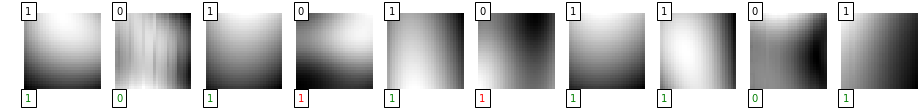

In [21]:
def make_image(X):
    im = np.swapaxes(X.T, 0, 1)
    im = im - im.min()
    im = im * 1.0 / im.max()
    return im

plt.figure(figsize=(16, 5))
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow(make_image(x_test[i][0]), interpolation='nearest', cmap=plt.get_cmap('gray'))
    true = y_test[0][i]
    pred = FPGA_predicted[i]
    color = 'green' if true == pred else 'red'
    plt.text(0, 0, true, color='black', bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 32, pred, color=color, bbox=dict(facecolor='white', alpha=1))

    plt.axis('off')

### ARM CPU Deployment

In [22]:
batch_size = 50
start_time = time.time()

%time prob = np.array(lasagne.layers.get_output(net['out'], floatX(x_test[0:batch_size]), deterministic=True).eval())
predicted = np.argmax(prob, 1)

end_time = time.time()
print(end_time-start_time)

CPU times: user 2.8 s, sys: 1.61 s, total: 4.41 s
Wall time: 2.21 s
2.2265231609344482


### Check our accuracy
We expect around 90%

In [23]:
accuracy = np.mean(predicted == y_test[0][0:batch_size])
# print(predicted)
# print(test_label[0][0:batch_size])
print(accuracy)

1.0
